# Sampling Distributions

## Objectives

  - Define population and sample.
  - Use scatterplots, histograms, and the empirical CDF to visualize a sample.
  - Define what it means for a sample to be independent and identically distributed.
  - Define the sampling distribution of a statistic.
  - Use bootstrapping to approximate the distribution of a statistic.
  - Use bootstrapping to approximate a confidence interval for a population parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Always make it pretty.
plt.style.use('ggplot')
font = {'weight': 'bold',
        'size':   16}
plt.rc('font', **font)

## Review: Fundamental Concepts

### Random Variables, Again.

Recall that a *random variable* $X$ is an object that can be used to generate numbers, in a way that valid probabilistic statements about the generated numbers can be made.  For example:

\begin{align} 
P(X > 0) &= 0.5 \\
P(-1 < X < 1) &= 0.25 \\
P(X < 0) & = 0 \\
P(X > 1 \mid X > 0) &= 0.5 
\end{align}

are all probabilistic statements about an unknown random variable.

From a programming perspective, a random variable is a type of object that implements a single public method: `sample`.

In [2]:
class RandomVariable:
    
    def __init__(self, parameters):
        self._parameters = parameters
        
    def sample(self):
        '''Return a random sample from the variable.'''
        return algorithm_for_sampling_from_this_variable()

### Distribution and Density Functions

One very general probabilistic statement we can make about a random variable is to compute the *function*

$$ F_X(t) = P(X \leq t) $$

this is called the **cumulative distribution function** (or sometimes **CDF** for short).  In a sense we could make precise, it says everything we can hope to say about the random variable.

If the distribution function is differentiable, then it's [derivative (rate of change)](https://en.wikipedia.org/wiki/Derivative) is called the **probability density function**. 

$$ f_X(t) = F_X'(t) $$

The density function satisfies the following property

$$ P(t_0 < X \leq t_1) = \int_{t_0}^{t_1} f(t) dt $$

### Summary

When we want to compute probabilities involving some random quantity, we can either:

  - Evaluate the distribution function.
  - Integrate the density function.

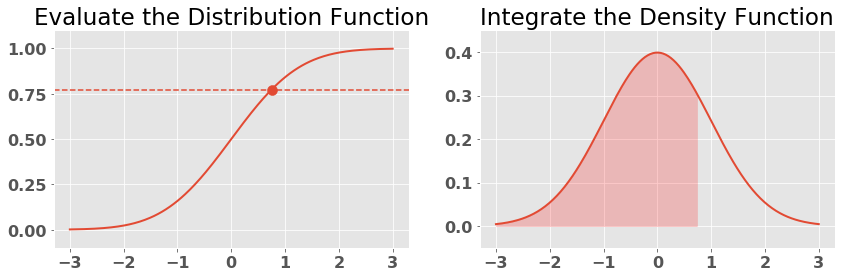

In [3]:
mean = 0
stdev = 1
normal = stats.norm(mean, stdev)

x = np.linspace(-3, 3, num=250)
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(x, normal.cdf(x), linewidth=2)
ax[0].scatter(0.75, normal.cdf(0.75), s=100)
ax[0].axhline(y=normal.cdf(0.75), linestyle="--") 
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_title("Evaluate the Distribution Function")

ax[1].plot(x, normal.pdf(x), linewidth=2)
ax[1].set_ylim(-0.05, 0.45)
ax[1].set_title("Integrate the Density Function")
_ = ax[1].fill_between(x, normal.pdf(x), 0, 
                   where=( (x <= 0.75) ),
                   color="red", alpha=0.2)
# ## change tick font size
# for i in [0,1]:
#     ax[i].tick_params(axis='both', which='major', labelsize=15)

If neither of these are avaialble, then we **cannot compute probabilities about the random variable**.

**Question:** What is the relationship between these two pictures?

### Identically Distributed

If two random variables have the *same* distribution function, we say they are *identically distributed*, and we denote this relationship

$$ X \sim Y $$

In practice this means **any probabilistic statements we make about $X$ and $Y$ have the same answer**.

## Probability vs. Statistics

Probability and Statistics are closely related subjects, but there is a fundamental difference.

### Probability

In **probability** we *know* the parameters of a distribution (associated with some random variable), and we would like to study properties of data generated from that distribution.

Example properties of random variables are

The **expectation** of a random variable is defined by

$$ E[X] = \int_{- \infty}^{\infty} t \
f_{X}(t) dt $$

and the **variance** is defined by

$$ V[X] = E \bigl[ (X - E[X])^2 \bigr] $$

If you *know* the parameters of the distribution, then you can *compute* the mean and variance.

### Statistics

In **statistics** we have data generated from a random variable, and we would like to *infer* properties of its distribution.

A few points are evident:

  - Independent and identically distributed data are important, as they allow us to pool information using data all generated from *indistinguishable* random variables.
  - We can never know *exactly* the distribution that generated the data, we can only hope to approximate it.
  - We *may* be able to quantify the uncertainty in our approximation (this is what much of classical statistics is about).

## A Useful Visualization

Suppose we have some static, fixed data.  Here's an example dataset:

In [4]:
np.random.seed(42)
mean = 0.1
stdev = 1.0
data = stats.norm(mean, stdev).rvs(100)
print(data)

[ 0.59671415 -0.0382643   0.74768854  1.62302986 -0.13415337 -0.13413696
  1.67921282  0.86743473 -0.36947439  0.64256004 -0.36341769 -0.36572975
  0.34196227 -1.81328024 -1.62491783 -0.46228753 -0.91283112  0.41424733
 -0.80802408 -1.3123037   1.56564877 -0.1257763   0.1675282  -1.32474819
 -0.44438272  0.21092259 -1.05099358  0.47569802 -0.50063869 -0.19169375
 -0.50170661  1.95227818  0.08650278 -0.95771093  0.92254491 -1.12084365
  0.3088636  -1.85967012 -1.22818605  0.29686124  0.83846658  0.27136828
 -0.01564828 -0.2011037  -1.37852199 -0.61984421 -0.36063877  1.15712223
  0.44361829 -1.66304016  0.42408397 -0.28508228 -0.576922    0.71167629
  1.13099952  1.03128012 -0.73921752 -0.20921238  0.43126343  1.07554513
 -0.37917424 -0.08565898 -1.00633497 -1.09620662  0.91252582  1.45624003
  0.02798988  1.1035329   0.46163603 -0.54511975  0.46139561  1.63803657
  0.06417396  1.66464366 -2.5197451   0.9219025   0.18704707 -0.19900735
  0.19176078 -1.88756891 -0.11967189  0.45711257  1

We'll probably learn more if we actually draw some pictures of this data set.  For a one dimensional data set there are a few options, but a scatter plot is always a good default choice because it

  - Shows all the data
  - Is easy to interpret
  - Doesn't lose any information

In [7]:
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    ## why jitter? especially for bootstraping later
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])
    ax.tick_params(axis='both', which='major', labelsize=15)

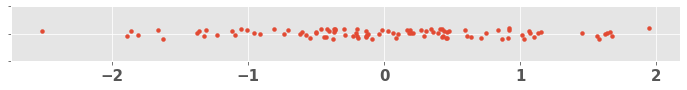

In [8]:
fig, ax = plt.subplots(1, figsize=(12, 1))
one_dim_scatterplot(data, ax, s=15)

### The Empirical Distribution Function

Another possibility for one dimensional data visualization is to plot the **empirical distribution function**:

In [13]:
def emperical_distribution(x, data):
    weight = 1.0 / len(data)
    count = np.zeros(shape=len(x))
    for datum in data:
        count = count + np.array(x >= datum)
    return weight * count

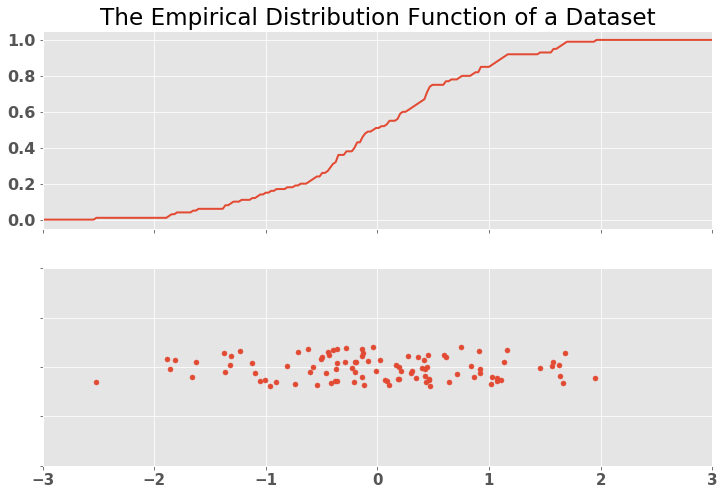

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

x = np.linspace(-3, 3, num=250)
ax[0].plot(x, emperical_distribution(x, data), linewidth=2)
ax[0].set_ylim(-0.05, 1.05)
ax[0].set_xlim(-3, 3)
# ax[0].tick_params(axis='both', which='major', labelsize=15)
one_dim_scatterplot(data, ax[1], s=25)
_ = ax[0].set_title("The Empirical Distribution Function of a Dataset")

**Question:** How is the EDF drawn? When does it increase?  How much does it increase each time?  What is it attempting to approximate?

# Sampling Theory

In this section we will take another path towards understanding samples taken from an unknown population.  Yesterday we fit statistical models to approximate the popuation, today we will study mathematical properties of the population itself.

## Sampling Distributions of Statistics

We need a way to mathematically model a simple random sample. For example, each of the following can be modeled as taking an i.i.d. random sample from a population:

  - A random survey of humans is an i.i.d. sample of all humans of interest to the survey designers.
  - A dataset of all the quotes received for an insurance product is an i.i.d. sample of all possible customers of the insurance company.
  - Driving around a city and turning a random direction at each intersection is an i.i.d. sample of all possible paths driven through the city (as long as you start in a random place).
  
When we have such a situation, we will adopt a slight change in perspective that will make our mathematics work out more easily:

**We consider each individual data point drawn from our population as the outcome from its own random variable.**

So, under this model, an i.i.d. sample can be thought of as a **sequence of random variables that are independent and identically distributed**

$$ X_1, X_2, X_3, \ldots, X_n $$

When we actually **physically take** the sample, i.e., **collect data**, we get datapoints $x_1, x_2, \ldots, x_n$, each one drawn from the corresponding random variable $X_k$.
  
A **statistic** is a function of a random sample $T(X_1, X_2, ..., X_n)$; i.e., something we can compute once we have a random sample.  Drawing different random samples will result in different values of the statistic.

### Examples of Statistics

Here are a couple simple and common statistics.  To illustrate, we've drawn 20 samples from a normal distribution and recorded the value of the statistic.

The **sample mean** is a statistic defined by $\displaystyle\frac{1}{n} \sum_i X_i$

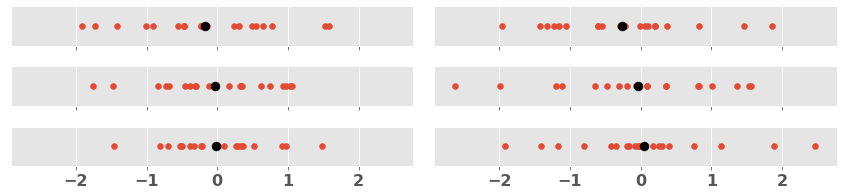

In [20]:
np.random.seed(42)
normal = stats.norm(0, 1)

fig, axs = plt.subplots(3, 2, figsize=(12, 3), sharex=True)

for ax in axs.flatten():
    samp = normal.rvs(20)
    ax.scatter(samp, np.repeat(0, 20))
    ## calculate the mean
    mean = np.mean(samp)
    ax.scatter([mean], 0, c="black", s=80)
    ax.tick_params(axis='both', which='major')
    ax.get_yaxis().set_ticks([])
plt.tight_layout()

The **sample maximum** is defined by $\max (X_1, X_2, \ldots, X_n)$

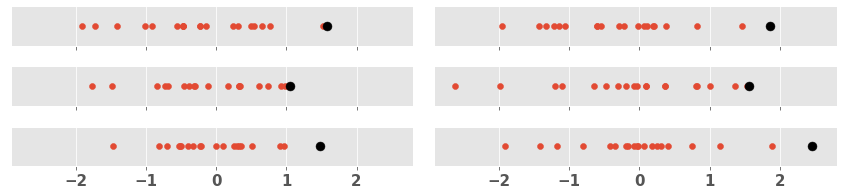

In [21]:
np.random.seed(42)
normal = stats.norm(0, 1)

fig, axs = plt.subplots(3, 2, figsize=(12, 3), sharex=True)

for ax in axs.flatten():
    samp = normal.rvs(20)
    ax.scatter(samp, np.repeat(0, 20))
    M = np.max(samp)
    ax.scatter([M], 0, c="black", s=80)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.get_yaxis().set_ticks([])
plt.tight_layout()

**Question:** What is another sample statistic that is commonly encountered?

**Question:** Explain in your own words why sample statistics are random variables.  

## The Main Question In Sampling Theory

### How do we **quantify** the amount of variation of a sample statistic?

To quantify the amount of variation of a statistic, we would really like a process like this:

  - Draw some number of independent and identically distributed data, $X$, i.e., a sample, from the population.
  - Compute the statistic using the sample you drew.
  - Record the value of the statistic just computed in a database.
  - Do it again, and again, and again, until the sun burns out.
  
After this process is complete, we have many examples of our statistic, each computed from a different random sample from our variable.

The distribution of *the statistic* that arises from this process is called the **sampling distribution of the statistic**.

### Example: Sample Means from A Normal Variable

Recall our sample means from the previous example:

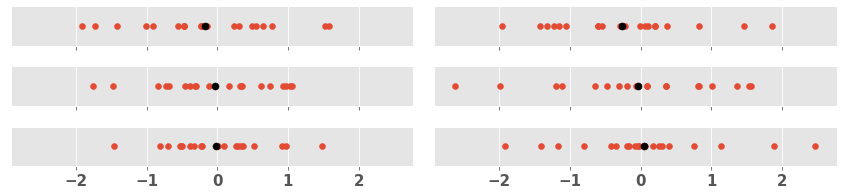

In [22]:
np.random.seed(42)
normal = stats.norm(0, 1)

fig, axs = plt.subplots(3, 2, figsize=(12, 3), sharex=True)

means = []
for ax in axs.flatten():
    samp = normal.rvs(20)
    ax.scatter(samp, np.repeat(0, 20))
    mean = np.mean(samp)
    means.append(mean)
    ax.scatter([mean], 0, c="black", s=50)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.get_yaxis().set_ticks([])
plt.tight_layout()

The distribution of the *black points* is the **sampling distribution of the mean**.

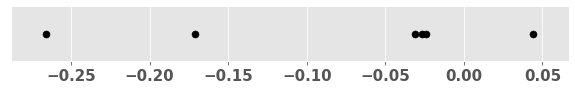

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 1))
ax.scatter(means, np.repeat(0, 6), c='black', s=50)
ax.tick_params(axis='both', which='major', labelsize=15)
_ = ax.get_yaxis().set_ticks([])

If we superimpose a sample from the original distribution, it's very clear that the spread of the sampling distribution is much smaller than that of the original.

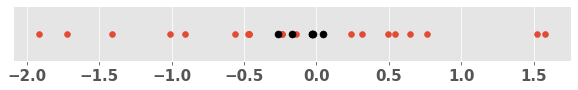

In [24]:
np.random.seed(42)
fig, ax = plt.subplots(1, 1, figsize=(10, 1))
ax.scatter(normal.rvs(20), np.repeat(0, 20))
ax.scatter(means, np.repeat(0, 6), c='black', s=50)
ax.tick_params(axis='both', which='major', labelsize=15)
_ = ax.get_yaxis().set_ticks([])

Two questions present themselves:

  - What is the average value of the statistic?
  - How much does the statistic vary around its average value?

## The Bootstrap

The central limit theorem is nice, it is a central result in mathematical statistics, and there is no other result in the subjects with the definitive nature of the CLT.

On the other hand, it has a huge drawback: **it only works for a single statistic, the sample mean!**  It would be nice to have a general procedure that will let us estimate the variance (or the entire distribution) of **any sample statisic**.

### Bootstrap Samples

We generally have one fixed dataset, which we view as a single sample from the population.  **The population is the object that interests us, and the sample is the lens through which we get to view it.**

The idea behind the bootstrap is that the **empirical distribution** of the sample should be our **best approximation** to the distribution of the population the sample is drawn from.  We can illustrate this by comapring the emperical distribution functions of samples to the actual population distribution functions:

In [25]:
# def superimpose_pdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
#     x = np.linspace(x_lower, x_upper, num=250)
#     ax.hist(data, bins=25, normed=True, color="black", alpha=0.4)
#     ax.plot(x, model.pdf(x), linewidth=3)
    
def superimpose_cdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    lwd = 3
    x = np.linspace(x_lower, x_upper, num=250)
    ax.plot(x, emperical_distribution(x, data),
            linewidth=lwd, alpha = .5, label = "sample")
    ax.plot(x, model.cdf(x), label = "population",
            linewidth=lwd, linestyle = "dashed")
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend()

def emperical_distribution(x, data):
    weight = 1.0 / len(data)
    count = np.zeros(shape=len(x))
    for datum in data:
        count = count + np.array(x >= datum)
    return weight * count

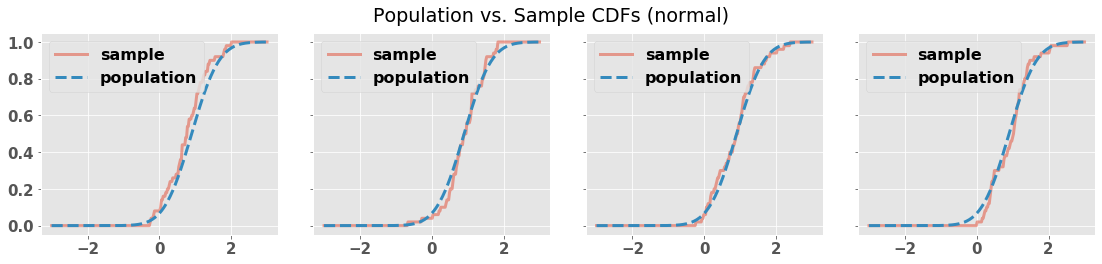

In [26]:
np.random.seed(42)
population = stats.norm(0.9, 0.6)

fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for ax in axs.flatten():
    sample = population.rvs(50)
    superimpose_cdf_of_fit_model(sample, population, ax)
fig.suptitle("Population vs. Sample CDFs (normal)")
plt.tight_layout(pad = 2)

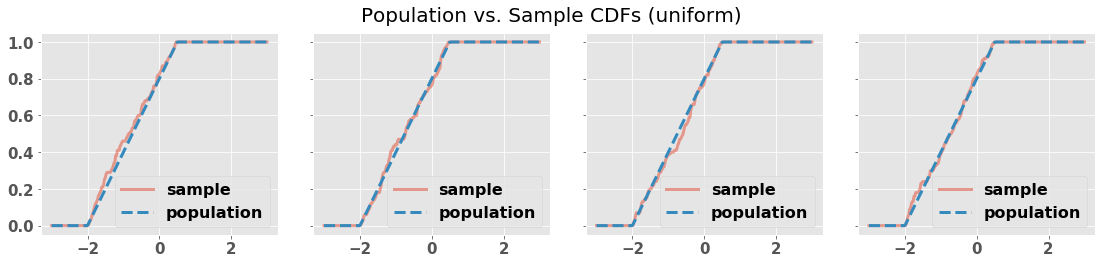

In [27]:
np.random.seed(42)
population = stats.uniform(-2, 2.5)

fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for ax in axs.flatten():
    sample = population.rvs(100)
    superimpose_cdf_of_fit_model(sample, population, ax)
fig.suptitle("Population vs. Sample CDFs (uniform)", fontsize=20)
plt.tight_layout(pad = 2)

This means that  **since we cannot repeatedly sample from the population, our next best bet is to sample from the sample itself**.

### Bootstrap: The Big Idea

We want to do this:

> Estimate the variance of a sample statistic by repeatedly sampling from the *population*, computing the sample means of these samples, and then computing the variance of the multiple sample means.

But we **can't**, because we can **only sample from the population one time**.

Instead, we repeatedly sample from our **best approximation to the population distribution**, which is given by the **empirical density function of the sample**.

That is, instead we do

> Estimate the variance of the sample means by repeatedly sampling from *a distribution approximating the population distribution*, computing the sample means of these samples, and then computing the variance of the multiple sample means.

### Definition

A **bootstrap sample** from a dataset is a sample taken with replacement from that dataset whose size is the size of the dataset itself.

In [29]:
def text_in_blank_plot(text, ax):
    '''make a text box'''
    _ = ax.text(0.5, 0.5, text, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=15)
    ax.axis('off')

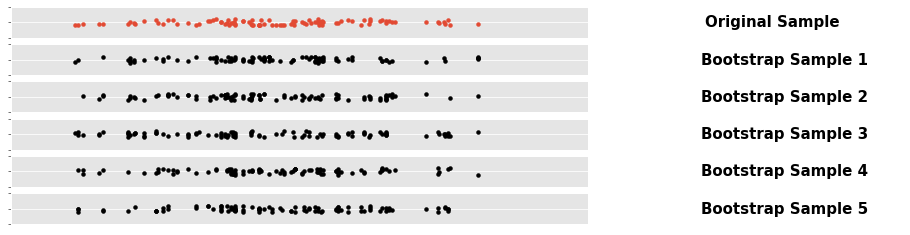

In [30]:
np.random.seed(42)
fig = plt.subplots(1, 1, figsize=(16, 4))

ax = plt.subplot2grid((6, 3), (0, 0), colspan=2) # Number of columns for the axis to span downwards.
ax.get_xaxis().set_ticks([])
ax.set_xlim(-2.5, 3)
one_dim_scatterplot(data, ax, s=15)

ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("Original Sample", ax)

## boostrapping 5 times
for i in range(0, 5):
    bootstrap = np.random.choice(data, size=len(data), replace=True)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.get_xaxis().set_ticks([])
    ax.set_xlim(-2.5, 3)
    one_dim_scatterplot(bootstrap, ax, s=15, c="black")
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1, sharex = ax)
    text_in_blank_plot("Bootstrap Sample {}".format(i+1), ax)
# plt.tight_layout()

Each bootstrap sample has it's **own** sample median

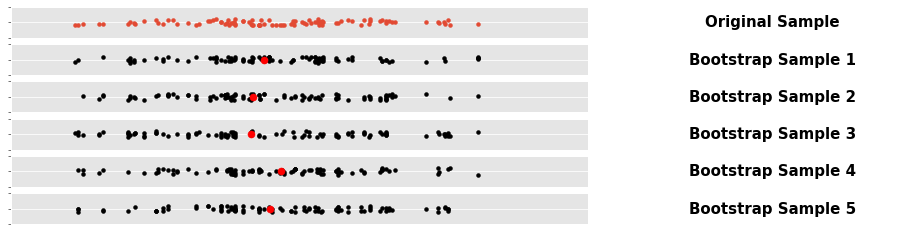

In [31]:
np.random.seed(42)
fig = plt.figure(figsize=(16, 4))
# colspan: Number of columns for the axis to span downwards.
ax = plt.subplot2grid((6, 3), (0, 0), colspan=2) 
ax.get_xaxis().set_ticks([])
ax.set_xlim(-2.5, 3)
one_dim_scatterplot(data, ax, s=15)

ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("Original Sample", ax)

## boostrapping 5 times
for i in range(0, 5):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.get_xaxis().set_ticks([])
    ax.set_xlim(-2.5, 3)
    one_dim_scatterplot(bootstrap_sample, ax, c="black", s=15)
    sample_median = np.median(bootstrap_sample)
    ax.scatter([sample_median], 0, c="red", s=50)
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Bootstrap Sample {}".format(i+1), ax)

The sample medians taken from repeated bootstrap samples are then an approximation to the **distribution of the sample medians**

In [32]:
def bootstrap_sample_medians(data, n_bootstrap_samples=10**4):
    bootstrap_sample_medians = []
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_sample_medians.append(np.median(bootstrap_sample))
    return bootstrap_sample_medians

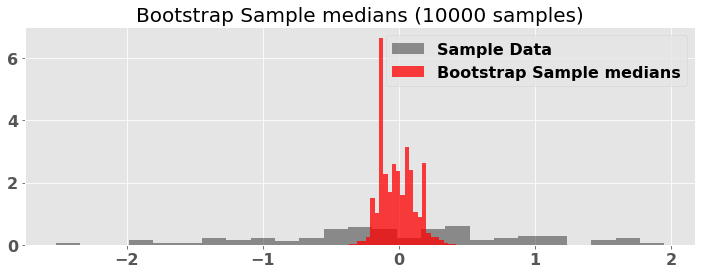

In [33]:
np.random.seed(321)
bootstrap_medians = bootstrap_sample_medians(data)

fig, ax = plt.subplots(1, figsize=(12, 4))
ax.hist(data, bins=25, density=True, color="black", alpha=0.4,
        label="Sample Data")
ax.hist(bootstrap_medians, bins=25, density=True, color="red", alpha=0.75,
        label="Bootstrap Sample medians")
ax.legend()
# ax.tick_params(axis='both', which='major', labelsize=15)
_ = ax.set_title("Bootstrap Sample medians (10000 samples)", fontsize = 20)

We can now use the bootstrap distribution of the sample meadian to estimate statistics that would otherwise be un-approchable.

In [34]:
variance_of_sample = np.var(data)
varaince_of_bootstrap_medians = np.var(bootstrap_medians)

print("Variance of Sample: {:2.2f}".format(variance_of_sample))
print("Variance of Sample medians: {:2.2f}".format(varaince_of_bootstrap_medians))

Variance of Sample: 0.82
Variance of Sample medians: 0.02


## Confidence Intervals: Capturing Population Parameters

Recall our statement from earlier

> Our general interest is in the **population**, the **sample** is just the lens we get to view it through.

We have shown that **sample statistics are generally good approximations of properties of the population**, and we have also discovered **methods for approximating the distribution of sample statistics**  such as bootstrapping and the central limit theorem.

Together these allow us to address a final question

> How good of an approximation of a population parameter is a sample statistic?

### Example: Bootstrap Confidence Interval for 75-th Percentile

Consider estimating a confidence interval of the 75-th percentile of a population.  In this case, the central limit theorem does not allow us to derive a mathematical form of the sampling distribution, instead we can proceed by using bootstrap sampling.

Here is the bootstrap procedure for computing a confidence interval for a 75-th percentile

  - Draw many bootstrap samples from your main sample, and for each:
    - Compute the sample statistic (using the bootstrap sample)
  - Gather together all the sample statistics of the various bootstrap samples into a list.
  
The resulting list can be considered as a sample from the sampling distribution of the statistic.

  - Compute the 95% confidence interval by finding the 0.025 and 0.975 percentiles of the resulting list of sample statistics.

In [40]:
np.random.seed(42)
bootstrap_sample_75_percentiles = []
for i in range(10000):
    bootstrap = np.random.choice(data, size=len(data), replace=True)
    bootstrap_75_percentile = np.percentile(bootstrap, 75)
    bootstrap_sample_75_percentiles.append(bootstrap_75_percentile)

This code creates an approximation the the sampling distribution of the statistic.

Text(0.5, 1.0, 'boostrap sample 75 percentiles')

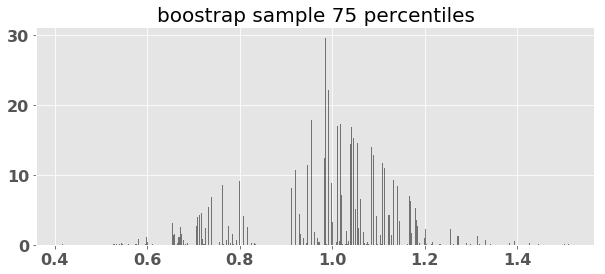

In [42]:
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.hist(bootstrap_sample_75_percentiles, bins=500, density=True, color="black", alpha=0.5)
ax.set_title("boostrap sample 75 percentiles", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=15)

We get a confidence interval by computing the 0.025 and 0.975 percentiles of the resulting sampling distribution approximation

In [43]:
left_endpoint = np.percentile(bootstrap_sample_75_percentiles, 2.5)
right_endpoint = np.percentile(bootstrap_sample_75_percentiles, 97.5)

print("Sample 75'th Percentile: {:2.2f}".format(np.percentile(data, 75)))
print("Bootstrap Confidence Interval for Population 75'th Percentile: [{:2.2f}, {:2.2f}]".format(
    left_endpoint, right_endpoint))

Sample 75'th Percentile: 1.02
Bootstrap Confidence Interval for Population 75'th Percentile: [0.67, 1.19]


**Question:** Why is this confidence interval not symmetric?

### Bootstrap: The Point

The Bootstrap is a tool to **quantify the variation in a statistical estimate**.  It can be used in almost **any** situation.

The bootstrap is a giant point in favor of the massive amount of computation all of us has at our disposal in modern day.  Before the computer age, the practice of statistics was tedious and mathematical.  Now we can estimate things earlier generations would **never have dreamed of** by simply putting to work some carefully engeneered slabs of silicon.